## Summary

Created: 10/28/2017 (cloned from part2_analysis_wasp21)

Note:
I initially used the chain produced from previous runs.
I ran a new mcmc because of ff changes:
* impact param is a free parameter instead of inclination
* sampling limb-darkening coeffs in q-space
* simpler systematics model

UPDATED:

* `*_rerun.py` with longer chains (nsteps=10000) were run using prometheus pc.
* The old chains and logprob results were migrated to old folder. 

In [2]:
import datetime as dt

print(dt.datetime.now())

2017-11-03 13:55:32.916164


In [3]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [4]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [5]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
from tqdm import tqdm

In [6]:
#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

## import lc

In [7]:
data_dir='.'

name='hatp44'
date='170215'
target_star_id='2'
comparison_star_id='13'#3
radii_range='9-14'

data={}
bands='g,r,z'.split(',')
sigma=5

for b in bands:
    fname='lcf_msct_'+b+'_'+name+'_'+date+'_t'+target_star_id+'_c'+comparison_star_id+'_r'+radii_range+'.bjd.dat'
    df=pd.read_csv(os.path.join(data_dir,fname), delimiter=' ', parse_dates=True)
    #manipulate columns
    cols = df.columns.tolist()
    cols.remove('#')
    cols.insert(-1,' ')
    df.columns = cols
    try:
        df=df.drop(['Unnamed: 21','frame', ' '],axis=1)
    except:
        pass
    df=df.set_index('BJD(TDB)-2450000')
    #df['BJD(TDB)'] = df['BJD(TDB)-2450000'].apply(lambda x: x + 2450000)
    #df=df.set_index('BJD(TDB)')
    #remove outliers
    data[b]=df[np.abs(df-df.mean())<=(sigma*df.std())]

In [8]:
import logging
fname = name+'_reduction.log'
logging.basicConfig(filename=fname, level=logging.INFO)

In [9]:
data[b].head()

airmass  sky(ADU)  dx(pix)  dy(pix)  fwhm(pix)  peak(ADU)  \
BJD(TDB)-2450000                                                              
7800.099704        1.9195     769.0    1.571    1.098       9.52     8484.4   
7800.100445        1.9101     759.6    1.183    1.363       9.05     8832.8   
7800.101185        1.9007     758.7    2.001    0.490       8.82     9166.4   
7800.101926        1.8915     757.1    2.197    1.278       8.82     9004.7   
7800.102655        1.8826     753.3    1.232    1.128       8.28     9894.7   

                  flux(r=9.0)  err(r=9.0)  flux(r=10.0)  err(r=10.0)  \
BJD(TDB)-2450000                                                       
7800.099704          1.008784    0.002271      1.005945     0.002288   
7800.100445          1.006547    0.002261      1.005888     0.002283   
7800.101185          1.014396    0.002273      1.012732     0.002296   
7800.101926          1.001108    0.002271      1.000193     0.002290   
7800.102655          1.010541    0.002235      1.009920     0.002263   

                  flux(r=11.0)  err(r=11.0)  flux(r=12.0)  err(r=12.0)  \
BJD(TDB)-2450000                                                         
7800.099704           1.004211     0.002324      1.003111     0.002372   
7800.100445           1.005840     0.002323      1.005248     0.002372   
7800.101185           1.011233     0.002333      1.010332     0.002383   
7800.101926           0.999210     0.002325      0.998171     0.002371   
7800.102655           1.009409     0.002305      1.009090     0.002359   

                  flux(r=13.0)  err(r=13.0)  flux(r=14.0)  err(r=14.0)  
BJD(TDB)-2450000                                                        
7800.099704           1.002090     0.002429      1.002103     0.002496  
7800.100445           1.005178     0.002431      1.003958     0.002494  
7800.101185           1.009567     0.002441      1.008458     0.002506  
7800.101926           0.998673     0.002430      0.999014     0.002494  
7800.102655           1.007839     0.002417      1.007942     0.002484

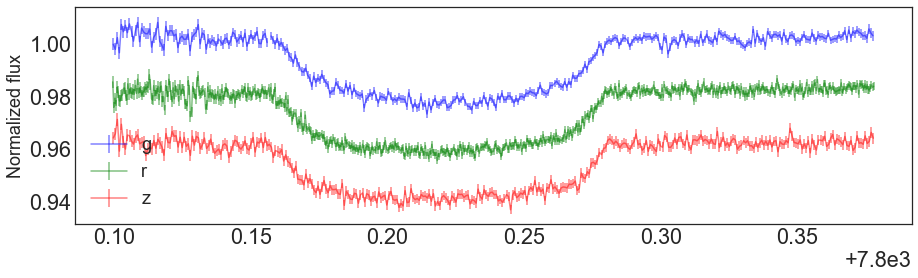

In [10]:
fluxcol =  'flux(r=11.0)'
errcol  =  'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux')
    n+=1
pl.legend(loc='lower left')

In [11]:
fig.savefig('figs/raw.png')

## building the model

* See [exoplanets.org](http://exoplanets.org/detail/HAT-P-44_b) for published transit parameters

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [12]:
tc_0  = 7.8e3+0.22
_P   = 4.301219
_t14 = 0.1302
_b   = 0.172
_a_s = 11.52
_k   = np.sqrt(0.01804)
_inc = np.deg2rad(89.10)

In [13]:
from pytransit import MandelAgol
MA = MandelAgol()

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def model_q(theta, t, p):
    '''
    p is an argument because it is well known from previous observation
    '''
    
    k,tc,a,ip,q1,q2 = theta[:6]
    inc   = np.arccos(ip/a)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, inc)
    return model

## Limb-darkening prior
* Limb-darkening coefficients inference from stellar parameters [Claret (2012)](https://www.aanda.org/articles/aa/pdf/2012/10/aa19849-12.pdf)

```
Uses table downloaded from:
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
band must be one of: B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*

log g below came from adopted model 11 (Table 11) of Hartmann+2014
```

In [14]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=5300,100, 4.460,0.06, 0.33,0.1
u1,u1err, u2,u2err = lb.claret('g*', teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
u1,u1err, u2,u2err

(0.74890000000000001,
 0.036786097690817934,
 0.072999999999999995,
 0.030001978911825131)

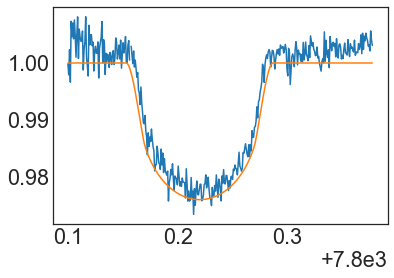

In [15]:
q1_, q2_       = u_to_q(u1, u2)
q1err_, q2err_ = u_to_q(u1err, u2err)


b='g'
f=data[b][fluxcol]
t=data[b].index

theta = [_k,tc_0,_a_s, _b, q1_, q2_]
m=model_q(theta, t, _P)

pl.plot(data[b].index,f)
pl.plot(t,m)

In [16]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=5300,100, 4.460,0.06, 0.33,0.1

#limbdark priors
ldp = []
for i in 'g*,r*,z*'.split(','):
    ldp.append(lb.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4)))

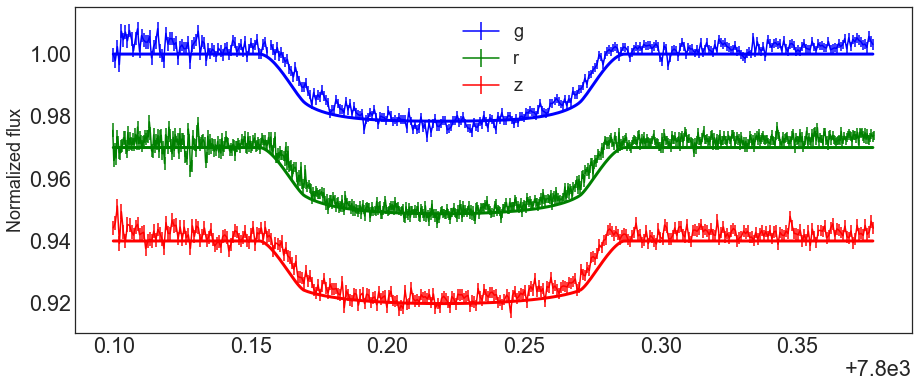

In [17]:
colors='b,g,r'.split(',')

fig,ax = pl.subplots(1,1,figsize=(15,6))

theta_vec = []

i = 0
for b,c in zip(bands,colors):
    df = data[b]
    
    offset = 0.03*i
    
    #plot data
    time = data[b].index
    flux = data[b][fluxcol]
    err  = data[b][errcol]
    
    ax.errorbar(time,flux-offset,yerr=err,color=c,label=b)
    
    #suppose k changes (gets slightly smaller from g to z band)
    k_0    = _k-0.001*i
    q1_,q2_ = ldp[i][0], ldp[i][2]
    
    #compute model
    theta = [k_0,tc_0,_a_s, _b, q1_, q2_]
    m=model_q(theta, t, _P)
    
    
    #plot model
    ax.plot(t,m-offset,color=c,lw=3)
    ax.set_ylabel('Normalized flux')
    theta_vec.append(theta)
    
    #increase counter
    i = i+1
    
pl.legend()

## MLE

* p, period
* k, r_planet/r_star
* t14, transit duration
* i, inclination
* b, impact paramter
* tc, mid-point transit time
* u1, u2, limb-darkening coeffs
* a_scaled

In [18]:
import scipy.optimize as op

def obj(theta, t, f, p, err):
    '''
    objective function: chi-squared
    '''
    m = model_q(theta, t, p)
    return np.sum((m-f)**2/err**2)

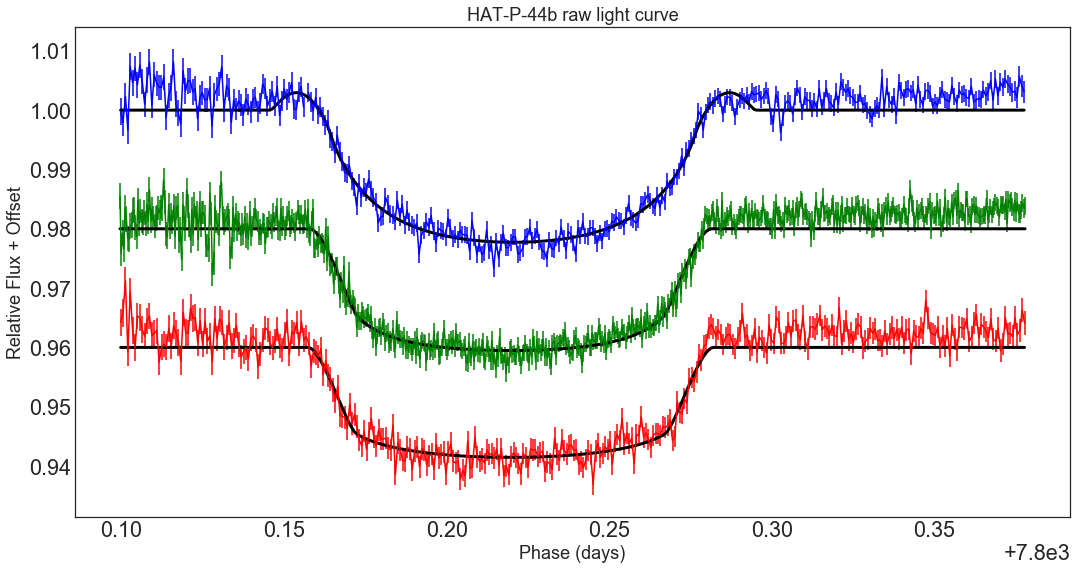

In [19]:
fontsize=18

ts,fluxes=[],[]
airmasses,errors,dxs,dys=[],[],[],[]

bands = sorted('g,r,z'.split(','))
colors='b,g,r'.split(',')

fig, axs = pl.subplots(1,1, figsize=(15,8), sharey=True)
for n,(b,c) in enumerate(zip(bands,colors)):
    df=data[b]    
    f=df[fluxcol]
    t=f.index
    err = df[errcol]
    
    ts.append(t)
    fluxes.append(f)
    
    #plot data
    #axs.plot(t,f-0.02*i, drawstyle='steps-mid', c=colors[i])
    axs.errorbar(t,f-0.02*n, yerr=err, color=c)
    res = op.minimize(obj, theta_vec[n], args=(t, f, _P, err), method='nelder-mead')
    model = model_q(res.x, t, _P)
    
    axs.plot(t, model-0.02*n, 'k-', lw=3);
    
    fig.tight_layout()

    
    #sys mod params
    airmasses.append(df['airmass'].values)
    errors.append(df['err(r=11.0)'].values)
    #peak_fluxes.append(d['peak'].values)
    #fwhms.append(d['fwhm'].values)
    dxs.append(df['dx(pix)'].values)
    dys.append(df['dy(pix)'].values)
    
axs.set_title('HAT-P-44b raw light curve',fontsize=fontsize)
axs.set_ylabel('Relative Flux + Offset',fontsize=fontsize)
axs.set_xlabel('Phase (days)',fontsize=fontsize)

In [20]:
#systematics model (time-dependent)
def model_s(theta, aux_vec, t):
    airmass, xcenter, ycenter = aux_vec
    #functional form of systematics model
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[airmass, xcenter, ycenter, offset, t]).sum(axis=1)
    #s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, err, aux_vec,
            ret_mod=False, ret_sys=False, ret_full = False):
    #airmass, xcenter, ycenter = aux_vec
    #ls = theta[6]
    m = model_q(theta[:6], t, p)
    s = model_s(theta[6:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    #C = np.log(2*np.pi)
    C = 0
    
    #-0.5*(np.sum((resid)**2 * np.exp(-2*ls) + 2*ls))
    
    return -0.5 * np.sum(C + np.log(err) + (resid**2/err**2))
    
    
#negative log-likelihood
nll = lambda *x: -loglike(*x)

In [21]:
q1_,q2_ = ldp[n][0], ldp[n][2]

k0, k1, k2, k3, k4, k5, k6, k7, k8, k9 = [0]*10
k_list= [k0, k1, k2, k3, k4, k5, k6, k7, k8, k9]
n_sysparams = 5

theta = [_k,tc_0,_a_s, _b, q1_, q2_]
theta_full = np.concatenate((theta, k_list[:n_sysparams]))

airmass   = df['airmass'].values
err       = df['err(r=11.0)'].values
dx        = df['dx(pix)'].values
dy        = df['dy(pix)'].values

aux_vec = (airmass, dx, dy)

In [22]:
%timeit nll(theta_full, t, f, _P, err, aux_vec)

1.72 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


--g--
NLL before: -500.7988188148303
NLL after: -926.3460432654545
residual: std=0.0020, rms=0.0020
--r--
NLL before: -1006.3903476288506
NLL after: -1814.3061533314506
residual: std=0.0018, rms=0.0018
--z--
NLL before: -661.0803479925278
NLL after: -973.4490845424627
residual: std=0.0020, rms=0.0020


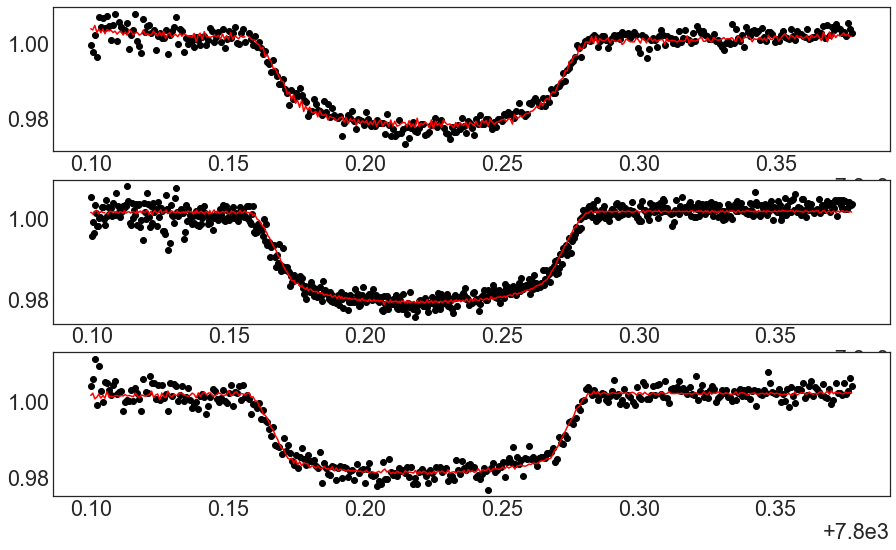

In [23]:
#systematics parameters
k0, k1, k2, k3, k4, k5, k6, k7, k8, k9 = [0]*10
#log flux uncertainty
k_list= [k0, k1, k2, k3, k4, k5, k6, k7, k8, k9]
n_sysparams=5

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

for n,b in enumerate(sorted(bands)):
    d=data[b]
    

    f=d[fluxcol]
    t=f.index

    #sys mod params
    airmass   = d['airmass'].values
    err       = d['err(r=11.0)'].values
    #peak_flux=d['peak(ADU)'].values
    #fwhm = d['fwhm(pix)'].values
    dx        = d['dx(pix)'].values
    dy        = d['dy(pix)'].values
    fwhm      = d['fwhm(pix)'].values
    sky       = d['sky(ADU)'].values
    peak      = d['peak(ADU)'].values
    print('--{}--'.format(b))
        
    k_0    = _k-0.001*n
    q1_,q2_ = ldp[n][0], ldp[n][2]
    
    theta = [k_0,tc_0,_a_s, _b, q1_, q2_]
    theta_full = np.concatenate((theta, k_list[:n_sysparams]))
    
    aux_vec = (airmass, dx, dy)
    print ("NLL before: {}".format(nll(theta_full, t, f, _P, err, aux_vec)))
    
    result = op.minimize(nll, theta_full,    args=(t, f, _P, err, aux_vec), 
                         method='nelder-mead')
    print ("NLL after: {}".format(nll(result.x,    t, f, _P, err, aux_vec)))

    f_pred = loglike(result.x, t, f, _P, err, aux_vec, ret_full=True)
    mod    = loglike(result.x, t, f, _P, err, aux_vec, ret_mod=True)
    sys    = loglike(result.x, t, f, _P, err, aux_vec, ret_sys=True)
    
    resid=f-f_pred #f-mod-sys
    sigma=np.std(resid)
    rms=np.sqrt(np.mean(resid**2))
    print('residual: std={0:.4f}, rms={1:.4f}'.format(sigma, rms))
    
    ax = pl.subplot(3,1,n+1)
    ax.plot(t, f, 'ko', t, f_pred, 'r-');

In [24]:
fig.savefig('figs/model-MLE.png')

In [25]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    a/Rs: scaled semi-major axis
    
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

_t14  = 0.13020
_b    = 0.172
a_s_  = scaled_a(_P, _t14, _k, i=_inc, impact_param=_b)
a_s_

11.809211418629959

In [26]:
import numpy as np
from uncertainties import ufloat 
from astropy import units as u

P   = ufloat(4.301219,0.000019)
Rp  = ufloat(1.523,0.442)   #+0.442-0.226

Rs_jup  = 0.949*u.Rsun.to(u.Rjup)
Rs_jup_u= 0.08*u.Rsun.to(u.Rjup) #+0.08/-0.037
Rs  = ufloat(Rs_jup,Rs_jup_u)

t14 = ufloat(0.1302,0.0008) 
b   = ufloat(0.172,0.079)   #+0.079/-0.074     
a_s = ufloat(11.52,0.74)
k   = ufloat(np.sqrt(0.01804),np.sqrt(0.00027)) 
inc = ufloat(np.deg2rad(89.10),np.deg2rad(0.4))

In [27]:
Rp/Rs

0.16491840817134548+/-0.04984031996673391

In [28]:
k

0.13431306712304653+/-0.016431676725154984

In [29]:
from uncertainties.umath import *

num   = ((k + 1)**2 - b**2)**(0.5)
denom = sin(inc) * sin(t14 * np.pi / P)

#uncertainty in a_s
a_s = num/denom
a_s

11.809211418629959+/-0.22844457501225646

In [30]:
def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = np.arccos(b/a)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

In [31]:
tshape = tshape_approx(_a_s, _k, _b)
kmax = max_k(tshape)
kmax

0.1384877403319339

## MCMC

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

In [32]:
from scipy import stats
def logprior(theta,up=None):
    '''
    up: u prior
    '''
    k,tc,a,impact_param,q1,q2 = theta[:6]
    inc=np.arccos(impact_param/a)
    
    #or k from 0 up to order of max_k (Seager paper)?
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0.1 or k  > kmax or \
        impact_param < 0 or impact_param  > 0.99 or \
        tc  < tc_0-_t14/2 or tc > tc_0+_t14/2:
            
        #print('off limits encountered in logprior')
        return -np.inf

    lp = 0
    #u prior
    u1,u2 = q_to_u(q1,q2)
    
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))
    
    return lp

def logprob(theta_sys,ts,fluxes,p,errors,airmasses,dxs,dys,up=None):
    t1,t2,t3 = ts
    f1,f2,f3 = fluxes
    err1,err2,err3 = errors
    airmass1,airmass2,airmass3 = airmasses
    xcen1,xcen2,xcen3 = dxs
    ycen1,ycen2,ycen3 = dys
    k1,k2,k3,tc,a_s,impact_param,q11,q12,q13,q21,q22,q23,\
    k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43 = theta_sys
    
    theta1 = [k1,tc,a_s,impact_param,q11,q21,k01,k11,k21,k31,k41]
    theta2 = [k2,tc,a_s,impact_param,q12,q22,k02,k12,k22,k32,k42]
    theta3 = [k3,tc,a_s,impact_param,q13,q23,k03,k13,k23,k33,k43]
    
    aux_vec1 = airmass1, xcen1, ycen1
    aux_vec2 = airmass2, xcen2, ycen2
    aux_vec3 = airmass3, xcen3, ycen3
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, f1, p, err1, aux_vec1)
    ll += loglike(theta2, t2, f2, p, err2, aux_vec2)
    ll += loglike(theta3, t3, f3, p, err3, aux_vec3)
    
    if up is not None:
        lp  = logprior(theta1,up=up[0])
        lp += logprior(theta2,up=up[1])
        lp += logprior(theta3,up=up[2])
    else:
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        #print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

sanity check

In [33]:
theta_vec=[]
for i,j in enumerate(bands):
    #assume k changes as function of wavelength
    k_0    = _k-0.001*i
    q1_,q2_ = ldp[i][0], ldp[i][2]
    theta = [k_0,tc_0,_a_s, _b, q1_, q2_]
    theta.append(theta_vec)

k1,k2,k3     = [_k+0.001,_k+0.002,_k+0.002]
#q1: g, r, z
q1g,q1r, q1z = ldp[0][0], ldp[1][0], ldp[2][0]
#q2: g, r, z
q2g,q2r, q2z = ldp[0][2], ldp[1][2], ldp[2][2]

#systematics parameters
k01, k11, k21, k31, k41 = [0] * 5
k02, k12, k22, k32, k42 = [0] * 5
k03, k13, k23, k33, k43 = [0] * 5


#log flux uncertainty
#ls1,ls2,ls3 = [np.log(np.nanstd(f)) for f in fluxes]  
t1,t2,t3         = ts
f1,f2,f3         = fluxes
xcen1,xcen2,xcen3= dxs
ycen1,ycen2,ycen3= dys
airmass1,airmass2,airmass3=airmasses
#fwhm1,fwhm2,fwhm3= fwhms
#unc1,unc2,unc3   = uncs

### withiout ldp

In [34]:
theta_full = [k1,k2,k3,tc_0,_a_s,_b,q1g,q1r,q1z,q2g,q2r,q2z,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43]
args = [ts,fluxes,_P,errors,airmasses,dxs,dys]

In [35]:
#without ldp
logprob(theta_full, *args)

1750.4131001128192

### with ldp

In [36]:
#with ldp
logprob(theta_full, *args, up=ldp)

1281.7856153389089

In [37]:
#with ldp
theta_full = [k1,k2,k3,tc_0,_a_s,_b,q11,q12,q13,q21,q22,q23,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43]
args = [ts,fluxes,_P,errors,airmasses,dxs,dys,ldp]

## Run mcmc

## Initial results: Parameter best estimates (including burn-in)

In [ ]:
#new results
import gzip
loc='.'

with gzip.GzipFile(os.path.join(loc,'chain1.npy.gz'), "r") as g:
    chain=np.load(g)
chain.shape

In [126]:
#load
loc = '.'

import gzip

with gzip.GzipFile(os.path.join(loc,'lnp1.npy.gz'), "r") as g:
    #lnp=g.read()
    lnp=np.load(g)
lnp.shape

(2560000,)

## excluding burn-in

In [127]:
import gzip
loc='.'

with gzip.GzipFile(os.path.join(loc,'chain2.npy.gz'), "r") as g:
    chain2=np.load(g)
chain2.shape

(256, 10000, 32)

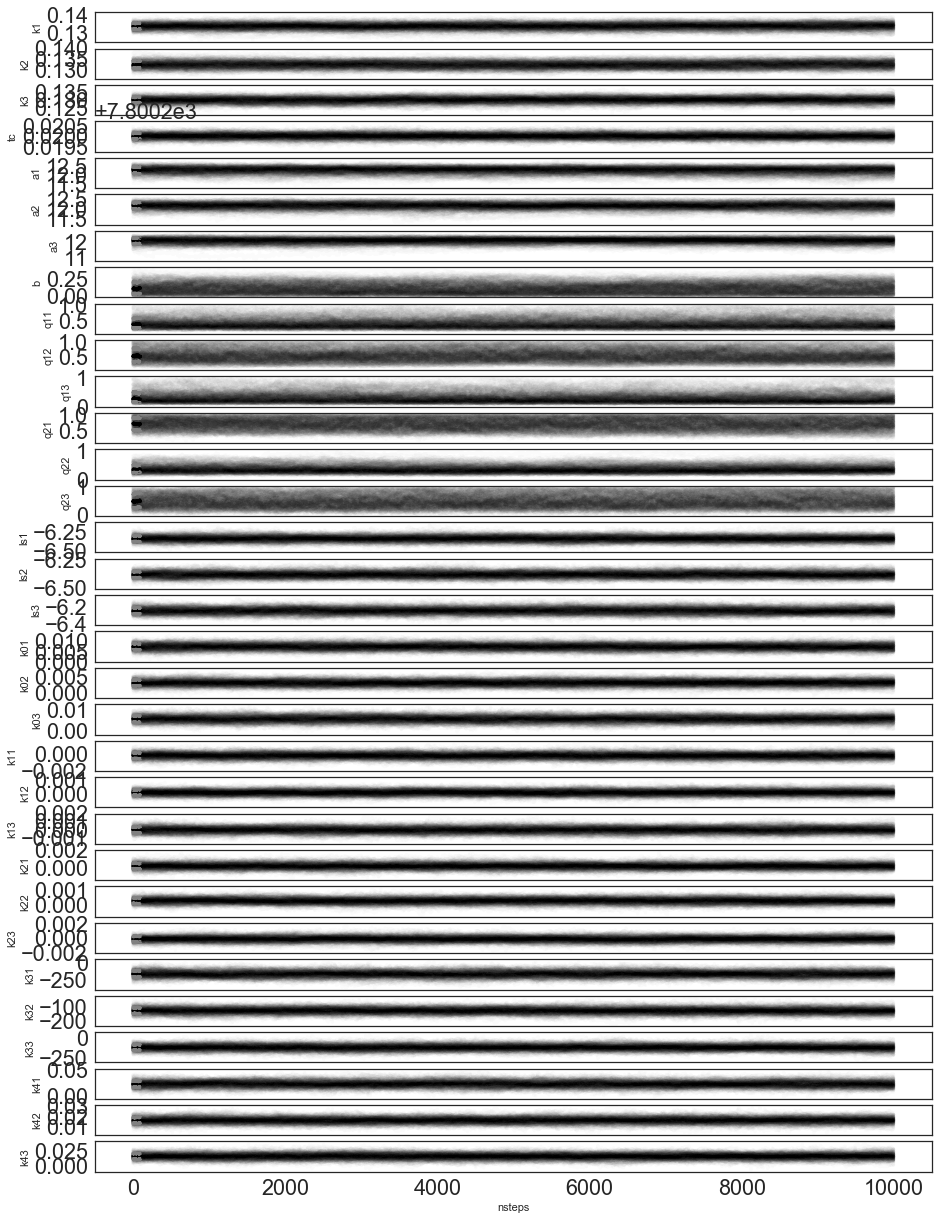

In [128]:
pl.style.use('seaborn-white')

param_names='k1,k2,k3,tc,a_s,b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')
thin = 100

nwalkers, nsteps, ndim = chain2.shape
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [np.percentile(chain2[:,::thin,i], [50,16,84], 0) for i in range(ndim)]
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain2.T)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
pl.xlabel('nsteps')

In [129]:
fig.savefig('figs/chain2.png')

In [130]:
burn=9000
fc = chain2[:,burn:,:].reshape([-1,chain2.shape[-1]])
fc.shape

(256000, 32)

In [131]:
del chain2

In [132]:
#load
with gzip.GzipFile(os.path.join(loc,'lnp2.npy.gz'), "r") as g:
    lnp2=np.load(g)
lnp2.shape

(2560000,)

In [133]:
#remove burnin
lnp2=lnp2[nwalkers*burn:]
lnp2.shape

(256000,)

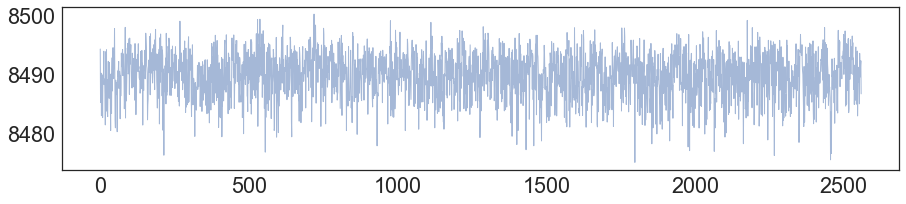

In [134]:
thin=100

fig=pl.figure(figsize=(15,3))
pl.plot(lnp2[::thin], lw=1, alpha=0.5)

## Results

Compare the above results to previous [published results](http://exoplanet.eu/catalog/HAT-P-44_b/).

In [135]:
#using full chain excluding burn-in
max_idx=np.argmax(lnp2) #fc_lnprob

#posterior of parameter vector
pv=fc[max_idx,:]

for n, i in zip(param_names, pv): 
    print('{0}: {1:.4f}'.format(n,i))

k1: 0.1354
k2: 0.1364
k3: 0.1279
tc: 7800.2199
a1: 12.0338
a2: 12.0386
a3: 11.4026
b: 0.2578
q11: 0.2847
q12: 0.2417
q13: 0.8215
q21: 0.8833
q22: 0.5957
q23: 0.2396
ls1: -6.4048
ls2: -6.3802
ls3: -6.2086
k01: 0.0088
k02: 0.0021
k03: 0.0051
k11: -0.0003
k12: 0.0001
k13: -0.0005
k21: 0.0003
k22: 0.0007
k23: 0.0002
k31: -217.4978
k32: -97.7526
k33: -114.6509
k41: 0.0279
k42: 0.0125
k43: 0.0147


In [136]:
final_theta=np.copy(pv)

In [137]:
np.save('theta_post.csv',final_theta)

In [138]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=param_names)
df.describe()

k1           k2           k3           tc           a1  \
count  256000.0000  256000.0000  256000.0000  256000.0000  256000.0000   
mean        0.1336       0.1325       0.1299    7800.2200      12.2280   
std         0.0019       0.0016       0.0019       0.0001       0.2036   
min         0.1259       0.1273       0.1233    7800.2194      11.3014   
25%         0.1324       0.1315       0.1287    7800.2199      12.1081   
50%         0.1336       0.1326       0.1299    7800.2200      12.2534   
75%         0.1349       0.1337       0.1312    7800.2201      12.3756   
max         0.1397       0.1378       0.1374    7800.2205      12.7529   

                a2           a3           b          q11          q12  \
count  256000.0000  256000.0000  2.5600e+05  256000.0000  256000.0000   
mean       12.1258      12.0722  1.2503e-01       0.4311       0.5305   
std         0.1768       0.1977  8.1746e-02       0.1716       0.1900   
min        11.4284      11.2678  6.0486e-07       0.1528       0.1095   
25%        12.0106      11.9439  5.4877e-02       0.3033       0.3892   
50%        12.1407      12.0941  1.1477e-01       0.3844       0.5106   
75%        12.2524      12.2122  1.8866e-01       0.5069       0.6503   
max        12.6465      12.6318  3.8014e-01       1.0000       0.9998   

          ...              k13         k21          k22         k23  \
count     ...       2.5600e+05  2.5600e+05  256000.0000  2.5600e+05   
mean      ...      -6.5851e-05  1.7527e-04       0.0003 -1.6195e-04   
std       ...       3.7469e-04  3.1155e-04       0.0002  3.8545e-04   
min       ...      -1.5024e-03 -1.2352e-03      -0.0005 -1.6839e-03   
25%       ...      -3.1993e-04 -3.1820e-05       0.0001 -4.2963e-04   
50%       ...      -7.6686e-05  1.7115e-04       0.0003 -1.6484e-04   
75%       ...       1.9534e-04  3.7667e-04       0.0004  8.7413e-05   
max       ...       1.6656e-03  1.6172e-03       0.0010  1.4416e-03   

               k31          k32          k33          k41          k42  \
count  256000.0000  256000.0000  256000.0000  256000.0000  256000.0000   
mean     -169.9458    -127.7955    -127.3349       0.0218       0.0164   
std        48.0155      21.2584      36.7182       0.0062       0.0027   
min      -373.8840    -199.5649    -299.4766      -0.0041       0.0043   
25%      -202.3142    -142.0661    -151.2729       0.0176       0.0146   
50%      -169.9466    -128.1807    -127.0752       0.0218       0.0164   
75%      -137.3692    -113.5960    -104.0220       0.0259       0.0182   
max        31.8659     -33.9141      15.8742       0.0479       0.0256   

               k43  
count  256000.0000  
mean        0.0163  
std         0.0047  
min        -0.0020  
25%         0.0133  
50%         0.0163  
75%         0.0194  
max         0.0384  

[8 rows x 32 columns]

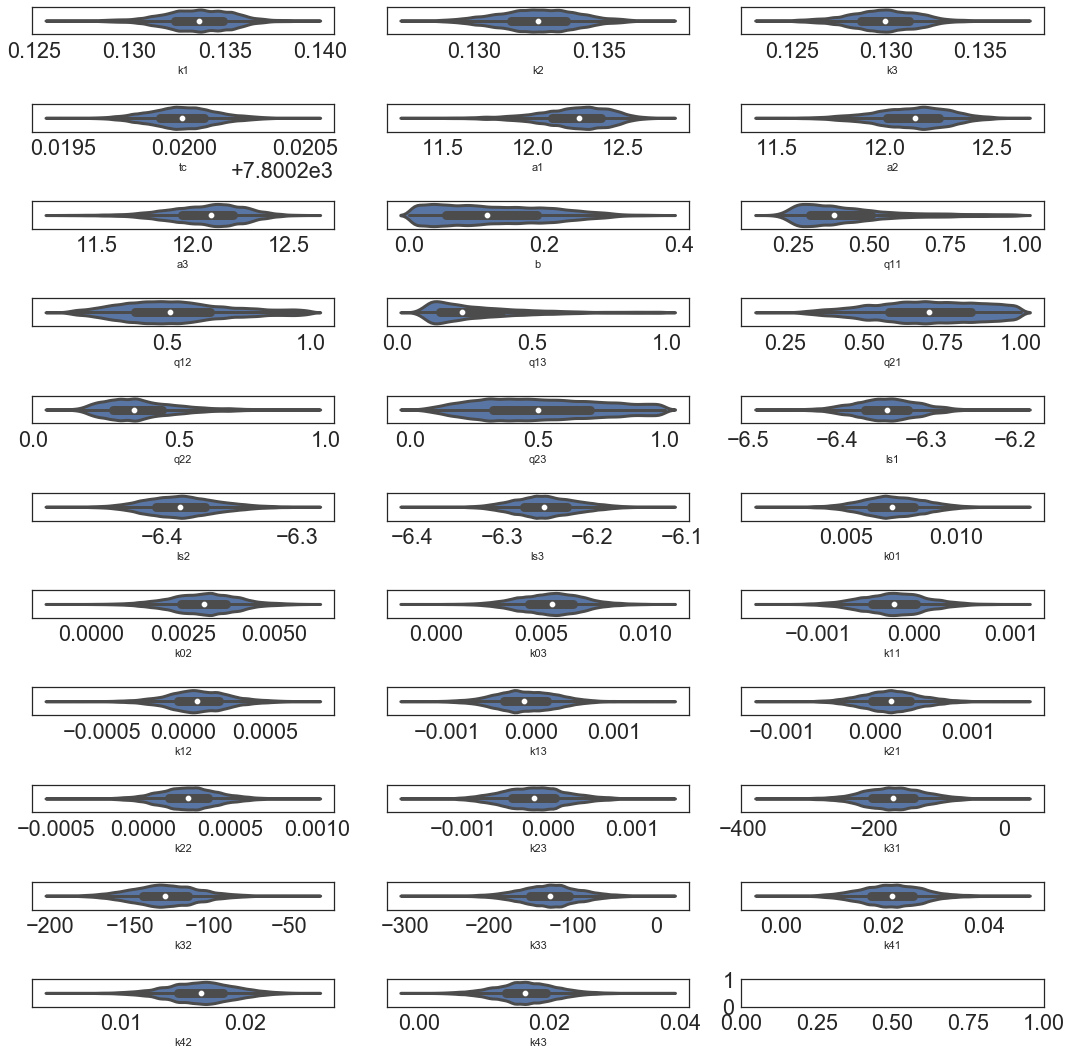

In [139]:
import seaborn as sb

with sb.axes_style('white'):
    fig, axs = pl.subplots(11,3, figsize=(15,15))
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(param_names)]
    #[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(param_names)]
    pl.setp(axs, ylabel='')
    fig.tight_layout()

In [140]:
fig.savefig('figs/params_aposteriori_distributions.png')

## BIC

In [141]:
def compute_bic(n,k,logL):
    '''
    n: number of data points
    m: number of parameters
    L: the maximized value of the likelihood function of the model
    '''
    return np.log(n)*m-2*logL

## Sample the flatchain

In [142]:
#100 samples from the posterior for each band 
mod_sys={}
sys={}
mod={}

# theta1 = [k1,tc,a1,inc,u11,u21,ls1,k01,k11,k21,k31,k41]
# theta2 = [k2,tc,a2,inc,u12,u22,ls2,k02,k12,k22,k32,k42]
# theta3 = [k3,tc,a3,inc,u13,u23,ls3,k03,k13,k23,k33,k43]

col1=[0,3,4,7,8,11,14,17,20,23,26,29]
col2=[1,3,5,7,9,12,15,18,21,24,27,30]
col3=[2,3,6,7,10,13,16,19,22,25,28,31]

In [143]:
[param_names[i] for i in col1]

['k1', 'tc', 'a1', 'b', 'q11', 'q21', 'ls1', 'k01', 'k11', 'k21', 'k31', 'k41']

$$
\rm \frac{no \; detection - expected \; value}{1\sigma \; bin} = 2.4 \; \sigma
$$

$$
P(\theta|D)\propto P(\theta) \times P(D|\theta) 
$$

In [144]:
mod_best = {}
sys_best = {}
full_best = {}
nsamples=1000

#params varies per band
for b,t,f,am,xc,yc,col in zip(bands,
                             [t1,t2,t3],
                             [f1,f2,f3],
                             [airmass1,airmass2,airmass3],
                             #[unc1,unc2,unc3],
                             [xcen1,xcen2,xcen3],
                             [ycen1,ycen2,ycen3],
                            [col1,col2,col3]):
    mod_sys[b]=[]
    sys[b]=[]
    mod[b]=[]
    
    aux_vec = [am, xc, yc]
    
    #get 100 samples from the posterior
    for th in fc[np.random.randint(0, fc.shape[0], size=nsamples)]:
    #with replacement/ bootstrap
    #for th in [np.random.choice(fc[:,:]) for j in range(1000)]:
        '''
        th is a huge vector, get only necessary params 
        in the form of theta1,2,3 above:
        loglike(theta, t, f, p, dx, dy, dummy)
        '''
        cc=[]
        #get proper columns for theta
        for c in col:
            cc.append(th[c])
            #theta = [k1,tc,a1,impact_param,q11,q21,ls1,k01,k11,k21,k31,k41]
        mod_sys[b].append(loglike(cc, t, f, _P, aux_vec, ret_full=True))
        sys[b].append(loglike(cc, t, f, _P, aux_vec, ret_sys=True))
        mod[b].append(loglike(cc, t, f, _P, aux_vec, ret_mod=True))
    #best
    vv = []
    for v in col:
            vv.append(pv[v])
    mod_best[b] = loglike(vv, t, f, _P, aux_vec, ret_mod=True)
    sys_best[b] = loglike(vv, t, f, _P, aux_vec, ret_sys=True)
    full_best[b] = loglike(vv, t, f, _P, aux_vec, ret_full=True)

check mean distribution for n samples sampled m times

### transit model

In [145]:
pv[3]

7800.2198954566493

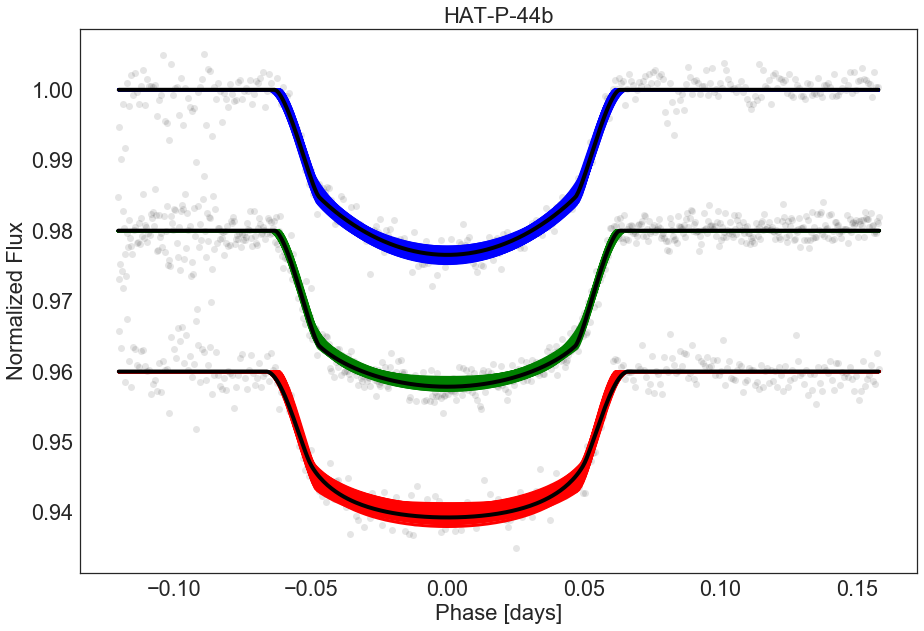

In [146]:
pl.style.use('seaborn-white')
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

colors='b,g,r'.split(',')
tc_hat=pv[3]
fontsize=22

labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']

fig,ax=pl.subplots(1,1,figsize=(15,10))
for n,(b,c,l) in enumerate(zip(bands,colors,labels)):
    ax.plot(ts[n]-tc_hat, fluxes[n]-sys_best[b]-0.02*n, 'ko', alpha=0.1)
    for i in mod[b]:
        ax.plot(ts[n]-tc_hat, i-0.02*n,'-', color=c, label=l)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, mod_best[b]-0.02*n, 'k-', lw=4)
    #plt.setp(ax.get_xticklabels(), visible=False)
ax.set_title('HAT-P-44b',fontsize=fontsize)
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('Phase [days]', fontsize=fontsize)
#ax.legend(labels,loc='lower right',fontsize=fontsize)

In [147]:
fig.savefig('figs/1000_posterior_samples.png')

### systematics model

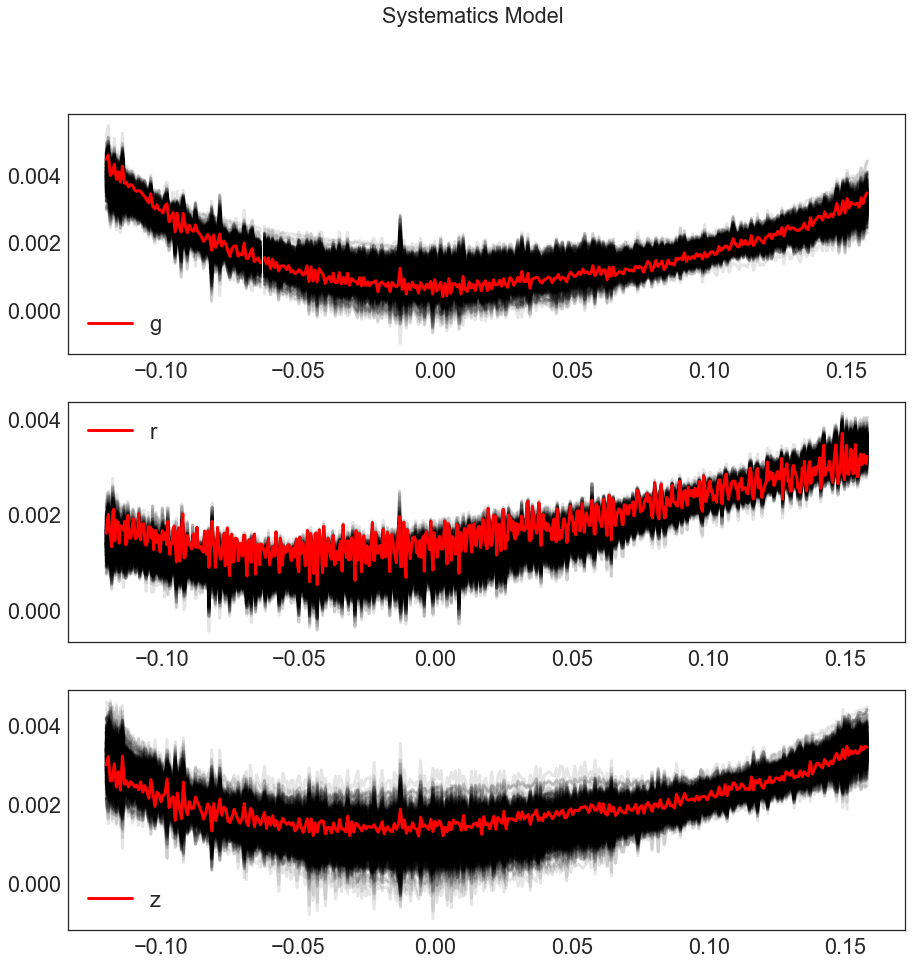

In [160]:
tc_hat=pv[3]
fig = pl.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    for i in sys[b]:
        pl.plot(ts[n]-tc_hat, i,'k-',alpha=0.1)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, sys_best[b], 'r-',label=b)
    ax.legend(fontsize=fontsize, loc='best')
pl.suptitle('Systematics Model')

In [161]:
fig.savefig('figs/sys.png')

### systematics + transit

In [150]:
tc_hat=pv[3]
fig = pl.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    for i in mod_sys[b]:
        pl.plot(ts[n]-tc_hat, i,'k-')
    #superpose best fit
    ax.plot(ts[n]-tc_hat, full_best[b], 'r-', label=b)
    ax.legend(fontsize=fontsize, loc='best')
pl.suptitle('Systematics+Transit Model')

In [151]:
fig.savefig('figs/transit with sys.png',bbox_inches='tight',pad_inches=0.01)

In [152]:
def rms(x):
    return np.sqrt(np.nanmean(x**2))

In [153]:
thinning=10
for n,b in enumerate(bands):
    text=rms(fluxes[n]-sys_best[b]-mod_best[b])*100
    print('{}:\trms={}'.format(b,text))
    logging.info('{}:\trms={}'.format(b,text))

g:	rms=0.1998313611946966
r:	rms=0.18793257032780467
z:	rms=0.21317989386412037


## g-band

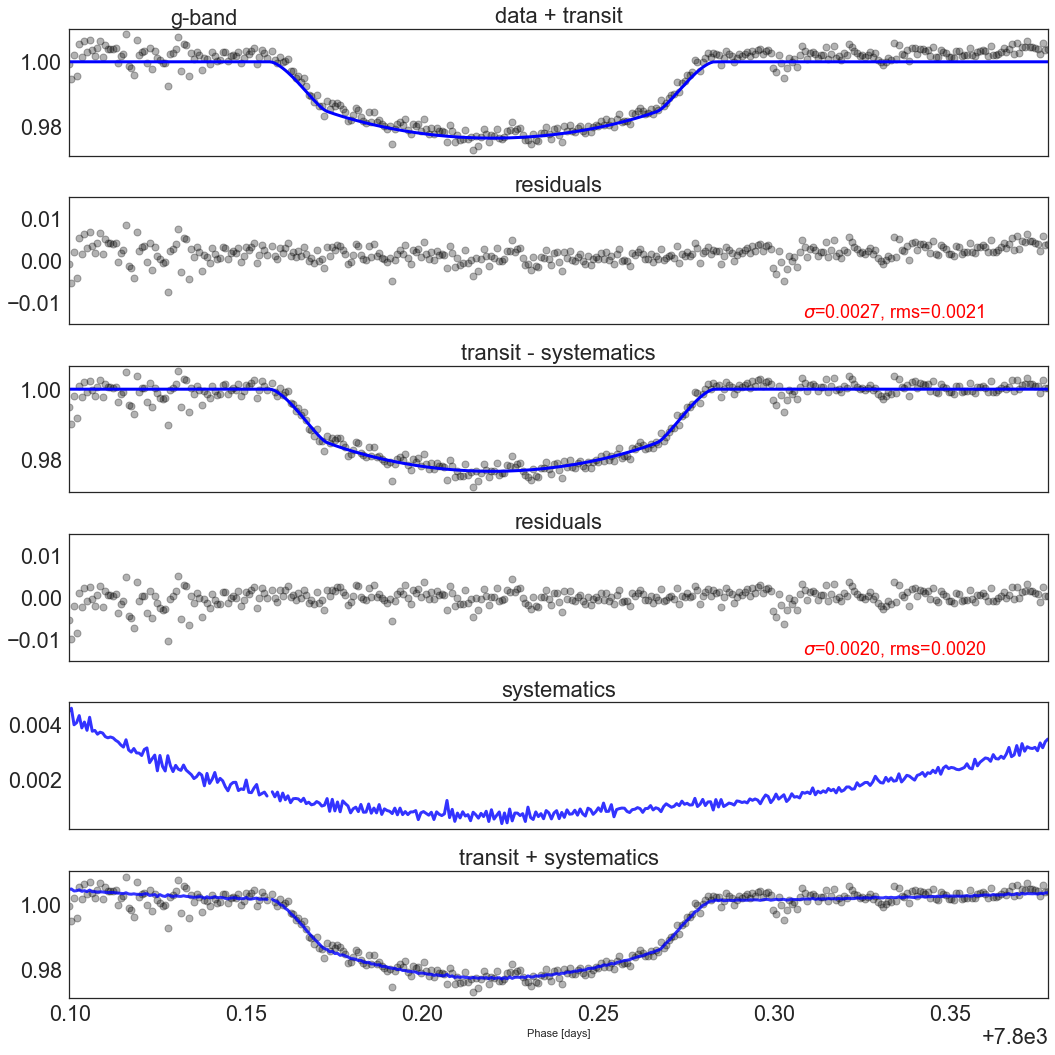

In [154]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
pl.rcParams['lines.linewidth'] = 3
n=0
b='g'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
pl.suptitle('{}-band'.format(b),x=0.2)

#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'b-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
res1=fluxes[n]-mod_best[b]
ax[1].plot(ts[n], res1, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res1),np.std(res1))
ax[1].text(0.75,0.05,res,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'b-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
res2=fluxes[n]-sys_best[b]-mod_best[b]
ax[3].plot(ts[n], res2, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res2),np.std(res2))
ax[3].text(0.75,0.05,res,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'b-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'b-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

In [155]:
fig.savefig('figs/summary_g.png')

## r-band

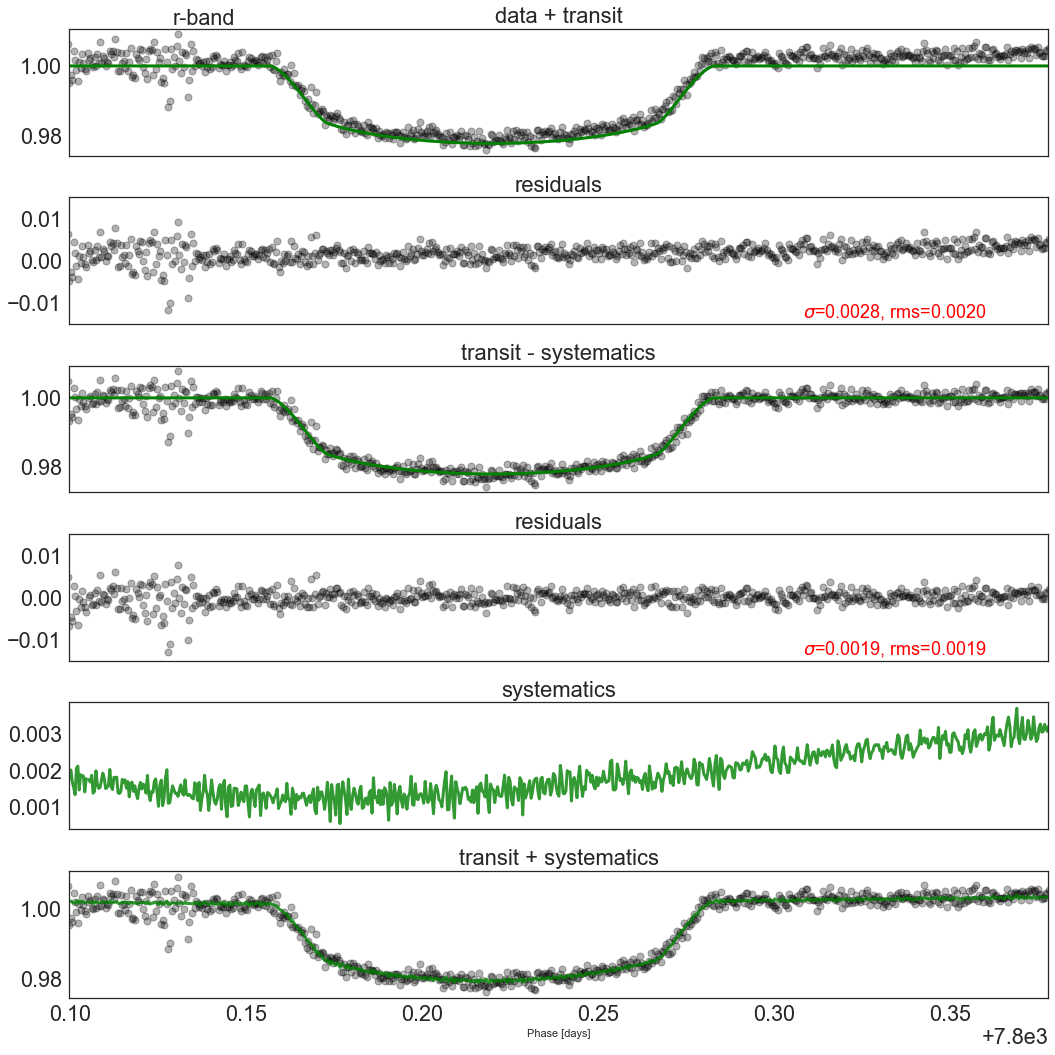

In [156]:
n=1
b='r'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
pl.suptitle('{}-band'.format(b),x=0.2)

#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'g-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
res1=fluxes[n]-mod_best[b]
ax[1].plot(ts[n], res1, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res1),np.std(res1))
ax[1].text(0.75,0.05,res,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'g-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
res2=fluxes[n]-sys_best[b]-mod_best[b]
ax[3].plot(ts[n], res2, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res2),np.std(res2))
ax[3].text(0.75,0.05,res,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'g-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'g-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

In [157]:
fig.savefig('figs/summary_r.png')

## z-band

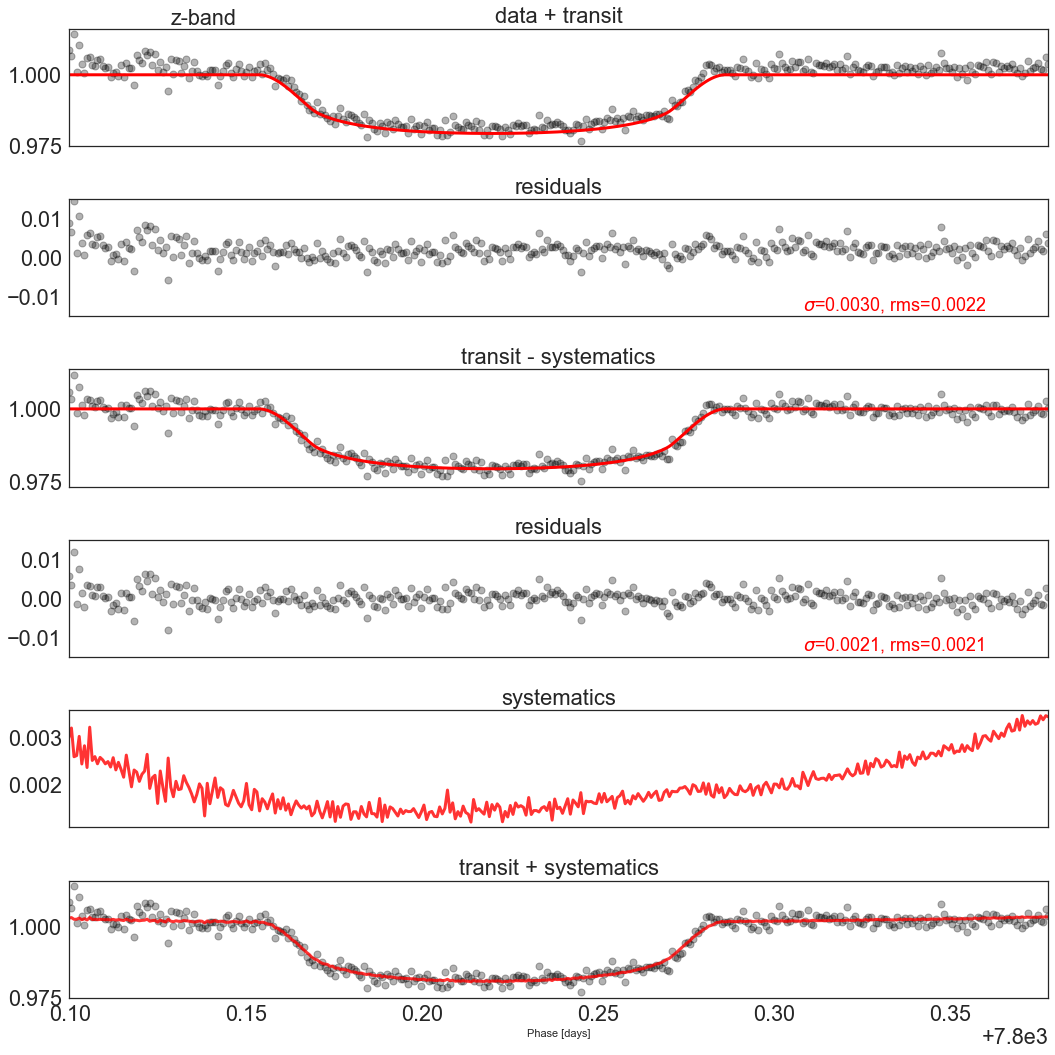

In [158]:
n=2
b='z'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
pl.suptitle('{}-band'.format(b),x=0.2)

#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'r-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
res1=fluxes[n]-mod_best[b]
ax[1].plot(ts[n], res1, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res1),np.std(res1))
ax[1].text(0.75,0.05,res,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'r-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
res2=fluxes[n]-sys_best[b]-mod_best[b]
ax[3].plot(ts[n], res2, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res2),np.std(res2))
ax[3].text(0.75,0.05,res,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'r-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'r-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

In [159]:
fig.savefig('figs/summary_z.png')

## binning
* See [stackoverflow](https://stackoverflow.com/questions/6163334/binning-data-in-python-with-scipy-numpy)

The binning must be less than t14 and/or t34. Based on the best fit model on the detrended light curve, t14 is about 0.01 to 0.02 day.

## binning before model fitting

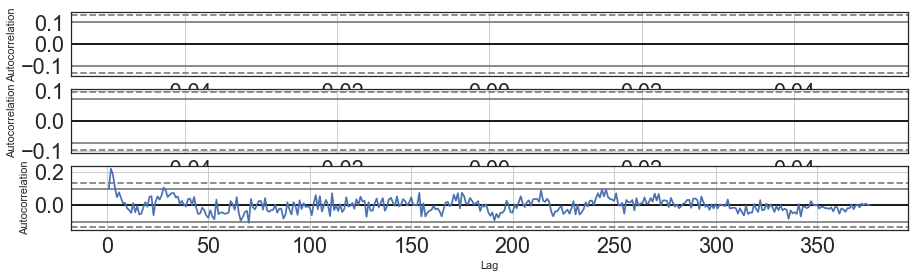

In [60]:
from pandas.plotting import autocorrelation_plot

fig = pl.figure(figsize=(15,8))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    autocorrelation_plot(fluxes[n]-sys_best[b]-mod_best[b], ax=ax)
    ax.set_title('{}-band'.format(b),fontsize=fontsize)
    #autocorrelation_plot(sys_best[b]-mod_best[b], ax=ax)
fig.tight_layout()

In [61]:
fig.savefig('figs/autocorr.png')

correlation: u1, u2; k1, k3; i, a

In [62]:
n,b=0,'g'
d1 = {'g_flux': fluxes[n], 'g_mod': mod_best[b], 'g_sys':sys_best[b], 'g_full': full_best[b], 'g(f-sys)': fluxes[n]-sys_best[b]}
df1=pd.DataFrame(data=d1, index=ts[n])

n,b=1,'r'
d2 = {'r_flux': fluxes[n], 'r_mod': mod_best[b], 'r_sys':sys_best[b], 'r_full': full_best[b], 'r(f-sys)': fluxes[n]-sys_best[b]}
df2=pd.DataFrame(data=d2, index=ts[n])

n,b=2,'z'
d3 = {'z_flux': fluxes[n], 'z_mod': mod_best[b], 'z_sys':sys_best[b], 'z_full': full_best[b], 'z(f-sys)': fluxes[n]-sys_best[b]}
df3=pd.DataFrame(data=d3, index=ts[n])

frames = [df1, df2, df3]

final_df = pd.concat(frames)
final_df.tail()

g(f-sys)  g_flux  g_full  g_mod  g_sys  r(f-sys)  r_flux  \
BJD(TDB)-2450000                                                             
7800.3748              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3756              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3763              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3771              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3778              NaN     NaN     NaN    NaN    NaN       NaN     NaN   

                  r_full  r_mod  r_sys  z(f-sys)  z_flux  z_full  z_mod  \
BJD(TDB)-2450000                                                          
7800.3748            NaN    NaN    NaN    1.0010  1.0042  1.0033    1.0   
7800.3756            NaN    NaN    NaN    0.9987  1.0021  1.0035    1.0   
7800.3763            NaN    NaN    NaN    0.9983  1.0016  1.0034    1.0   
7800.3771            NaN    NaN    NaN    1.0027  1.0061  1.0035    1.0   
7800.3778            NaN    NaN    NaN    1.0004  1.0038  1.0034    1.0   

                   z_sys  
BJD(TDB)-2450000          
7800.3748         0.0033  
7800.3756         0.0035  
7800.3763         0.0034  
7800.3771         0.0035  
7800.3778         0.0034

## Save

In [63]:
final_df.to_csv('after_mcmc_hatp44b.csv')

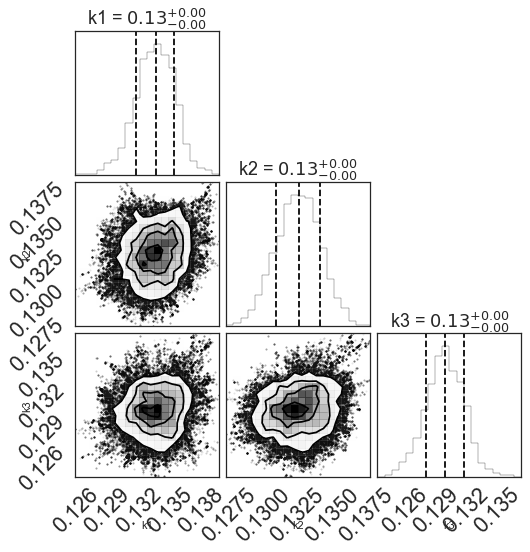

In [64]:
import corner


fig =  corner.corner(fc[:,:3], labels=param_names[:3], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [65]:
fig.savefig('figs/joint_k.png')

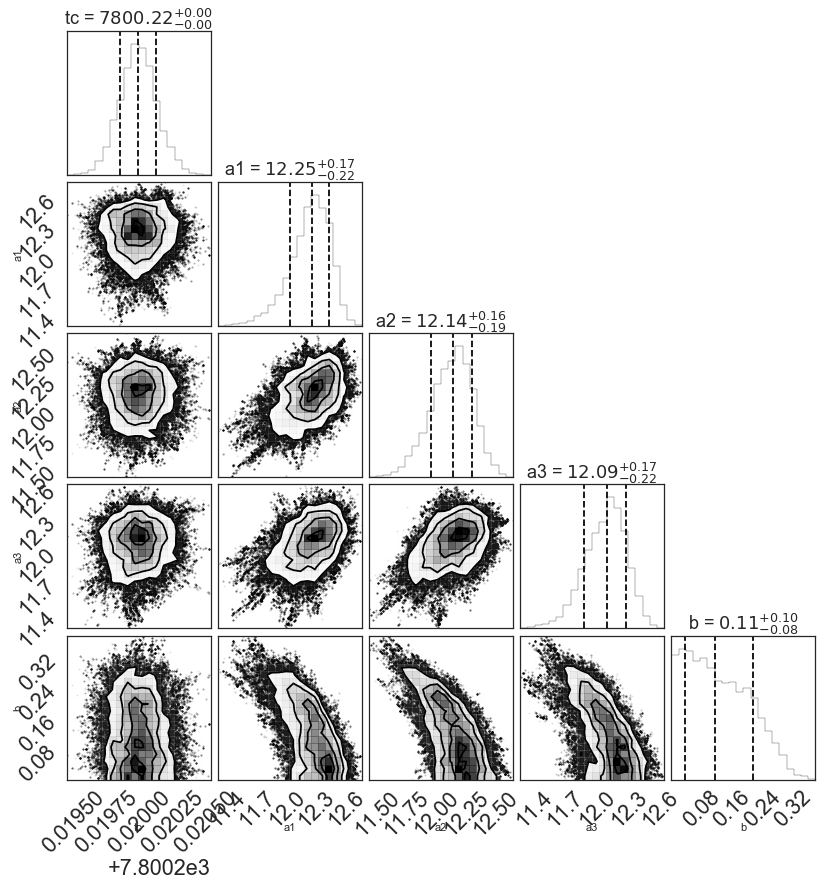

In [66]:
import corner

fig = corner.corner(fc[:,3:8], labels=param_names[3:8], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [67]:
fig.savefig('figs/joint_tc_a_b.png')

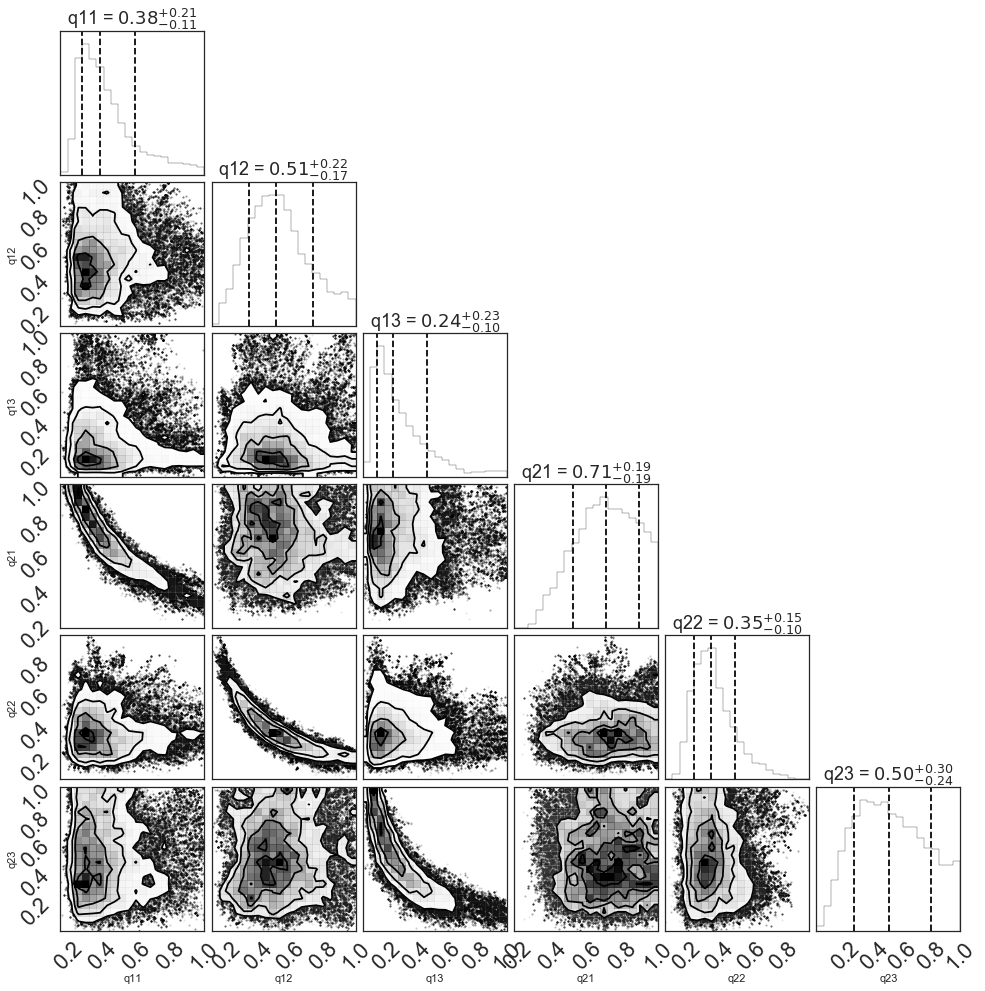

In [68]:
fig = corner.corner(fc[:,8:14], labels=param_names[8:14], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [69]:
fig.savefig('figs/limbdark_q1q2.png')

In [70]:
fig = corner.corner(fc[:,14:17], labels=param_names[14:17], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [71]:
fig.savefig('figs/logsigma.png')

In [72]:
fig = corner.corner(fc[:,17:], labels=param_names[17:], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [73]:
fig.savefig('figs/joint_coeffs.png')

## even sampling of time (index)

Add evenly sampled time to compensate for sparse data (resulting to edgy/not smooth model fits especially in limb-darkening areas.

### Reevaluate model using new evenly-sampled time

## best fit with uncertainties: credible intervals

In [74]:
post=[]
for i,(j,p) in enumerate(zip(pv,param_names)):
    fc_sample=fc[np.random.randint(0, fc.shape[0], size=1000)]
    sig_minus,mean,sig_plus=np.percentile(fc_sample[:,i], [16,50,84], axis=0)
    vals='{0}={1:.4f}\t- {2:.4f} \t+ {2:.4f}'.format(p,j,sig_minus,sig_plus)
    post.append(vals)
    print(vals)
    #print(mean)
np.save('post_with_unc_hapt44b.csv',post)

k1=0.1354	- 0.1319 	+ 0.1319
k2=0.1364	- 0.1309 	+ 0.1309
k3=0.1279	- 0.1282 	+ 0.1282
tc=7800.2199	- 7800.2199 	+ 7800.2199
a1=12.0338	- 12.0161 	+ 12.0161
a2=12.0386	- 11.9430 	+ 11.9430
a3=11.4026	- 11.8945 	+ 11.8945
b=0.2578	- 0.0309 	+ 0.0309
q11=0.2847	- 0.2763 	+ 0.2763
q12=0.2417	- 0.3480 	+ 0.3480
q13=0.8215	- 0.1345 	+ 0.1345
q21=0.8833	- 0.5057 	+ 0.5057
q22=0.5957	- 0.2404 	+ 0.2404
q23=0.2396	- 0.2574 	+ 0.2574
ls1=-6.4048	- -6.3802 	+ -6.3802
ls2=-6.3802	- -6.4137 	+ -6.4137
ls3=-6.2086	- -6.2860 	+ -6.2860
k01=0.0088	- 0.0056 	+ 0.0056
k02=0.0021	- 0.0022 	+ 0.0022
k03=0.0051	- 0.0038 	+ 0.0038
k11=-0.0003	- -0.0006 	+ -0.0006
k12=0.0001	- -0.0001 	+ -0.0001
k13=-0.0005	- -0.0004 	+ -0.0004
k21=0.0003	- -0.0002 	+ -0.0002
k22=0.0007	- 0.0001 	+ 0.0001
k23=0.0002	- -0.0006 	+ -0.0006
k31=-217.4978	- -220.3503 	+ -220.3503
k32=-97.7526	- -149.4498 	+ -149.4498
k33=-114.6509	- -165.4399 	+ -165.4399
k41=0.0279	- 0.0154 	+ 0.0154
k42=0.0125	- 0.0137 	+ 0.0137
k43=0.0147	- 0

In [75]:
pv[3]

7800.2198954566493

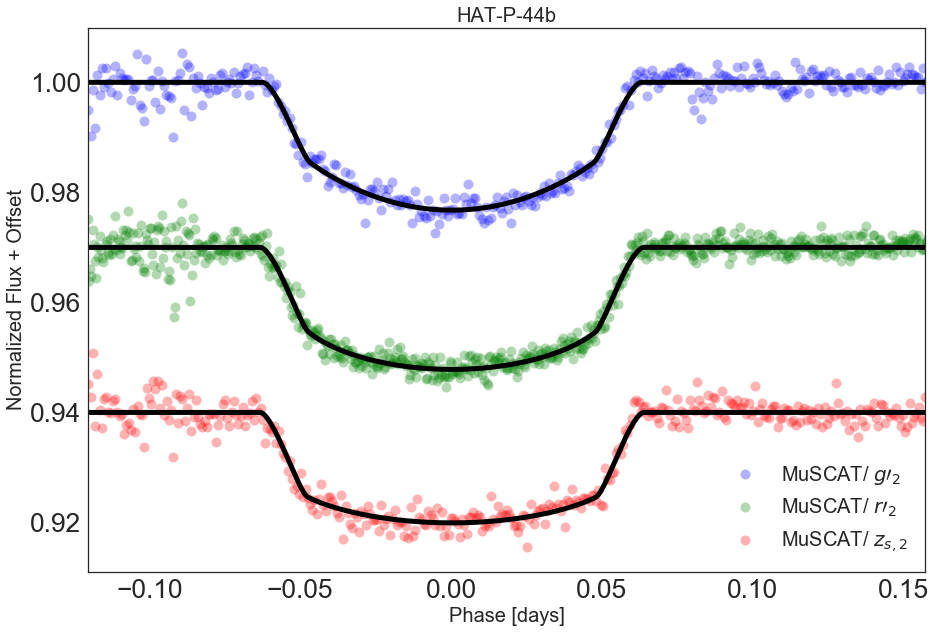

In [76]:
import matplotlib 
# # #matplotlib.rcParams.keys()
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 5})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=20

final_df=pd.read_csv('after_mcmc_hatp44b.csv', parse_dates=True, index_col=0)

tc=pv[3]
final_df.index=final_df.index-tc
fig,ax=pl.subplots(1,1,figsize=(15,10))
cols='g(f-sys),r(f-sys),z(f-sys)'.split(',')
colors=['b','g','r']
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']
clipped = 1
offset=0.03
for i,(col,c,l) in enumerate(zip(cols,colors,labels)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(
                marker='.', ms=20,
                alpha=0.3, linestyle='', linewidth=100,color=c, ax=ax,
                label=l)

cols2='g_mod,r_mod,z_mod'.split(',')
for i,(col,c) in enumerate(zip(cols2,colors)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(ax=ax, 
                                                    linewidth=5, color='k')
    
ax.set_xlabel('Phase [days]', fontsize=fontsize)
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
#ax.set_ylim(0.8,1)
ax.set_title('HAT-P-44b', fontsize=fontsize)
ax.legend(labels,loc='best', fontsize=fontsize)

In [77]:
fig.savefig('figs/grz.png')

## Best fit models and (binned) residuals
* binning3 function is not implemented because of NaNs; df.resample is better because it takes into account the actual time and not only the separation between data points (e.g. two consecutive data points might be NaN and it can be problematic after binning). 
* See `width` to check binning width in min

In [78]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 3})
from scipy import stats

final_df=pd.read_csv('after_mcmc_corot5b.csv', parse_dates=True, index_col=0)
#final_df = df.set_index(pd.to_datetime(df.index, unit='D', origin=offset))

from matplotlib import gridspec

fig = pl.figure(figsize=(15,8))

gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1, 1, 1],
                       height_ratios=[3, 1, 1],
                       wspace=0.1, 
                       hspace=0.1
                       )
clip=False
binn=False
clipped=20
binning='3T'
ylims= [0.97,1.01]
ylims2= [-0.01,0.01]

tc=pv[3]
final_df.index=final_df.index-tc

ax1 = pl.subplot(gs[0])
if clip==True:
    final_df.iloc[:-clipped]['g(f-sys)'].plot(marker='.',alpha=0.5, 
                                            linestyle='', color='k', ax=ax1)
elif binn==True:
    final_df['g(f-sys)'].resample(binning).mean().plot(marker='.', 
                                alpha=0.1, linestyle='-', color=colors[0], ax=ax1)
else:
    final_df['g(f-sys)'].plot(marker='.', 
                                alpha=0.5, linestyle='', color='k', ax=ax1)
final_df['g_mod'].plot(linestyle='-',alpha=0.8, color=colors[0], ax=ax1)

ax1.set_ylim(ylims)
ax1.set_title(r'MuSCAT/ $g\prime_2$',fontsize=fontsize)
ax1.set_xticklabels([])
ax1.set_ylabel('Relative Flux',fontsize=fontsize)
ax1.set_xlabel('')

ax2 = pl.subplot(gs[1])

if clip==True:
    final_df.iloc[:-clipped]['r(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[1], ax=ax2)
elif binn==True:
    final_df['r(f-sys)'].resample(binning).mean().plot(
        marker='.', alpha=0.1, linestyle='-', color=colors[1], ax=ax2)
else:
    final_df['r(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax2)
final_df['r_mod'].plot(alpha=0.8, linestyle='-', color=colors[1], ax=ax2)

ax2.set_ylim(ylims)
ax2.set_title(r'MuSCAT/ $r\prime_2$',fontsize=fontsize)
#ax2.axis()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlabel('')

ax3 = pl.subplot(gs[2])

if clip==True: #dropna, clip
    final_df.iloc[:-clipped]['z(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[2], ax=ax3)
elif binn==True: #bin
    final_df['z(f-sys)'].resample(binning).mean().plot(
        marker='.', ls='', alpha=0.1, linestyle='-', color=colors[2], ax=ax3)
else:
    final_df['z(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax3)
final_df['z_mod'].plot(linestyle='-', alpha=0.8, color=colors[2], ax=ax3)
    
ax3.set_ylim(ylims)
ax3.set_title(r'MuSCAT/ $z_{s,2}$',fontsize=fontsize)
ax3.set_xticklabels([])
ax3.set_xlabel('')
ax3.set_yticklabels([])

ax4 = pl.subplot(gs[3])
diff_g=final_df['g(f-sys)']-final_df['g_mod']
diff_g.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax4)
#diff_g.resample(binning).mean().plot(marker='.', ax=ax4)

# t_bin=binning3(ts[0],bins=n_min_binning['g'])
# res_bin=binning3(diff_g.values,bins=n_min_binning['g'])
# ax4.plot(t_bin,res_bin,'bo')
ax4.set_ylabel('Residuals',fontsize=fontsize)
ax4.set_ylim(ylims2)
#ax4.set_xticklabels([])
ax4.set_xlabel('Phase [days]',fontsize=fontsize)

ax5 = pl.subplot(gs[4])
diff_r=final_df['r(f-sys)']-final_df['r_mod']
diff_r.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax5)
#diff_r.resample(binning).mean().plot(marker='.', ax=ax5)

# t_bin=binning3(ts[1],bins=n_min_binning['r'])
# res_bin=binning3(diff_r.values,bins=n_min_binning['r'])
# ax5.plot(t_bin,res_bin,'go')
ax5.set_ylim(ylims2)
#ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax5.set_xlabel('Phase [days]',fontsize=fontsize)

ax6 = pl.subplot(gs[5])
diff_z=final_df['z(f-sys)']-final_df['z_mod']
diff_z.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax6)
#fit
slope, intercept, r_value, p_value, std_err = stats.linregress(diff_z.index-tc,diff_z)
y=slope*diff_z.index-tc+intercept
ax6.plot(diff_z.index,y,alpha=0.8, linestyle='-', color=colors[2])
#diff_z.resample(binning).mean().plot(marker='.', ax=ax6)

# t_bin=binning3(ts[2],bins=n_min_binning['z'])
# res_bin=binning3(diff_z.values,bins=n_min_binning['z'])
# ax6.plot(t_bin,res_bin,'bo')
ax6.set_ylim(ylims2)
#ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.set_xlabel('Phase [days]',fontsize=fontsize)

In [79]:
fig.savefig('figs/grz with rms.png')

## Comparison of k

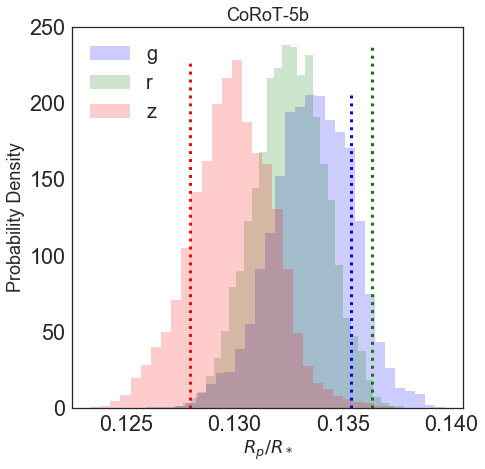

In [80]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

k_samples=[]

fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']

thin=1
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::thin,n]
    arr,bins,_=ax.hist(sampled,bins=30,color=c,histtype='stepfilled',
                       label=l,alpha=0.2,normed=True);
    #show aposteriori value
    #ymin,ymax = ax.get_ylim()
    ymin,ymax = 0,np.max(arr)
    ax.vlines(pv[n], ymin,ymax, linestyles='dotted', color=c)# ,label='map')
    
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('CoRoT-5b',fontsize=18)
pl.legend(fontsize=fontsize)

In [81]:
fig.savefig('figs/radius ratios.png')

In [82]:
np.mean(pv[:3])

0.13321971044680178

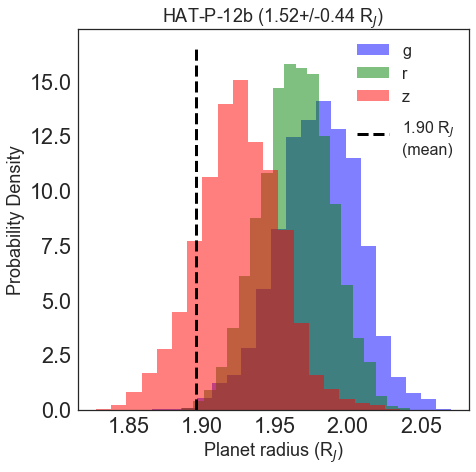

In [83]:
from astropy import units as u

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize = 18

Rs = ufloat(0.949,0.08) #+0.08/-0.037
Rs = Rp.nominal_value #*u.Rsun.to(u.Rjup) #± 0.04

k_samples=[]

fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']

thin=1
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::thin,n]
    factor=Rs*u.Rsun.to(u.Rjup)
    ax.hist(sampled*factor,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'Planet radius (R$_J$)',fontsize=fontsize)
    ax.set_ylabel('Probability Density',fontsize=fontsize)
#show mean of aposteriori values
mean=np.mean(pv[n]*factor)
pl.vlines(mean, *ax.get_ylim(), 
          linestyles='dashed', color='k', label='{:.2f} R$_J$\n(mean)'.format(mean))
pl.title('HAT-P-12b ({:.2f} R$_J$)'.format(Rp),fontsize=fontsize)
pl.legend(loc='best', fontsize=16)

In [84]:
Rp_ = np.mean(pv[:3])*factor
print('published value = {}\ncomputed \t= {}\ndifference\t= {}'.format(Rp,Rp_,Rp - Rp_))

published value = 1.5+/-0.4
computed 	= 1.974390012107513
difference	= -0.5+/-0.4


In [85]:
fig.savefig('figs/radius ratios Rjup.png')

In [86]:
sigma_g_minus,sigma_g_mean,sigma_g_plus= np.percentile(k_samples[0],[15.9,50,84.1])
sigma_z_minus,sigma_z_mean,sigma_z_plus= np.percentile(k_samples[2],[15.9,50,84.1])
#diff=sigma_g_mean-sigma_z_mean
diff=sigma_g_minus-sigma_z_plus

sig=np.sqrt(sigma_z_plus**2+sigma_g_minus**2)
print('sigma_rss={}'.format(sig))
print('diff={}'.format(diff))
print('sigma={}'.format(diff/sig))

sigma_rss=0.18635442151072518
diff=-8.764155109031169e-06
sigma=-4.702949915533273e-05


In units of Jupiter radius

## transmission spectrum

* See also procedure of [Nikolov+2016](https://arxiv.org/pdf/1610.01186.pdf)

In [87]:
for n in range(3):
    print(np.percentile(fc[::10,n],[50,16,84]))

[ 0.13364066  0.1317771   0.13542917]
[ 0.13257648  0.13088786  0.13417013]
[ 0.12991917  0.12806958  0.13177199]


In [88]:
pv[:3]

array([ 0.13536694,  0.13635166,  0.12794053])

* blue (g'2 : 400-550nm)
* red (r'2 : 550-700nm)
* NIR (zs,2 : 820-920nm)
* rp/rs=0.1343 (i-band)

slope=-0.000010


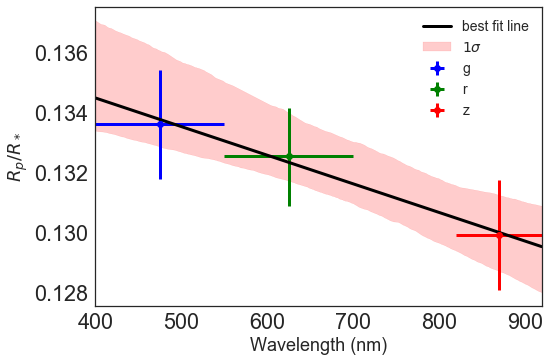

In [89]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

thin = 1

#bandwidths
xs1=[400,550,820]
xs2=[550,700,920]
#mean of each band
xmean=np.mean([xs1,xs2],axis=0)
ys=[]

#plot max aposteriori
fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84],axis=0)
    ys.append(y)
    
#fit a line to k1,k2,k3
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
#ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'k-')

#sample and fit slopes and intercepts from the posterior
nsamples = 10000
x = xmean
xi = np.linspace(400, 920, 500)
ys = []
lines = []
bands='g,r,z'.split(',')

for i in range(nsamples):
    y = fc[i,:3]
    slope,intercept,rvalue,pvalue,stderr = lg(xmean,y)
    line = slope * xi + intercept
    lines.append(line)
    
lo, hi, mid = np.percentile(lines, [16, 84, 50], axis=0)
ax.fill_between(xi, lo, hi, color='r', alpha=0.2, label='$1\sigma$')

#FIXME: not a line (curvy)!
#ax.plot(xi,mid,'k-',label='best fit line')

'''
#best fit line of the map of each k
ax.plot(xmean,pv[:3],'ko') #data points
slope,intercept,rvalue,pvalue,stderr = lg(xmean,pv[:3])
ax.plot(xi,xi*slope+intercept,'k-',label='best fit line')
'''
#plot error bar
new_axis=[]
for n,(x,c,b) in enumerate(zip(xmean,colors,bands)):
    yerr1,yerr2,y = np.percentile(fc[::thin,n],[16,84,50])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr = yerr, xerr=xerr, fmt='o',color=c, label=b) 
    new_axis.append(y*Rs)

#best fit line of the map of each k samples
slope,intercept,rvalue,pvalue,stderr = lg(xmean,ys)
ax.plot(xi,xi*slope+intercept,'k-',label='best fit line')

ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)
ax.set_xlim(400,920)
ax.legend(fontsize=14)

print('slope={:.6f}'.format(slope))

In [90]:
fig.savefig('figs/spectrum.png')

## significance of detection

In [91]:
slopes=[]
intercepts=[]
nsamples=1000

s1=k_samples[0][np.random.randint(0, k_samples[0].shape[0], size=nsamples)]
s2=k_samples[1][np.random.randint(0, k_samples[1].shape[0], size=nsamples)]
s3=k_samples[2][np.random.randint(0, k_samples[2].shape[0], size=nsamples)]

for ss1,ss2,ss3 in zip(s1,s2,s3): 
    slope,intercept,_,_,_=lg(xmean,[ss1,ss2,ss3])
    slopes.append(slope)
    intercepts.append(intercept)

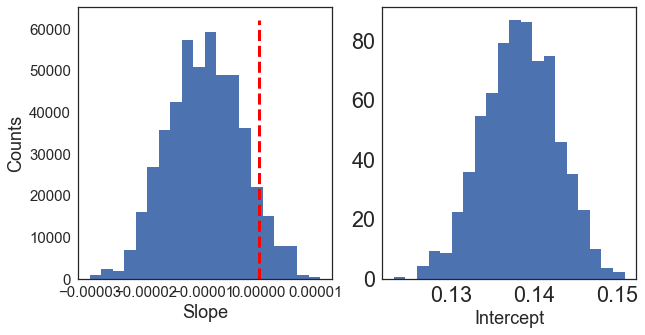

In [92]:
fig,ax=pl.subplots(1,2,figsize=(10,5))
ax[0].hist(slopes,bins=20,normed=True);
ax[0].vlines(0, *ax[0].get_ylim(), color='r', linestyle='dashed')
ax[0].set_ylabel('Counts',fontsize=fontsize)
ax[0].set_xlabel('Slope',fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].hist(intercepts,bins=20,normed=True);
ax[1].set_xlabel('Intercept',fontsize=fontsize)

In [93]:
fig.savefig('figs/slope.png')

From the posterior distribution of radius ratios, we took 1000 random samples each and computed the slope of the transmission spectrum (positioned at the center of the broadband filters). The histogram of the slope is shown in Fig. X consistent with negative values with 2.3 sigma.

In [94]:
x1,x2,x3=np.percentile(slopes,[50,15.9,84.1])
sig_plus=x3-x1
print((0-x1)/sig_plus)

1.43159106198
